In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- 1. Simulate Data Collection ---
# Create a sample dataset of 1000 gym visits over a few weeks.
num_records = 1000
start_date = datetime(2025, 10, 1)
student_ids = [f"BTECH{np.random.randint(10000, 10500)}//24" for _ in range(50)]

data = []
for _ in range(num_records):
    # Simulate realistic check-in times (busier in evenings)
    hour = int(np.random.normal(17, 4)) # Centered around 5 PM (17:00)
    hour = max(6, min(22, hour)) # Gym open from 6 AM to 10 PM
    minute = np.random.randint(0, 60)
    day = np.random.randint(0, 21) # 3 weeks of data

    check_in = start_date + timedelta(days=day, hours=hour, minutes=minute)

    # Simulate workout duration (average 60 mins)
    duration_minutes = max(15, int(np.random.normal(60, 25)))
    check_out = check_in + timedelta(minutes=duration_minutes)

    data.append({
        "AnonymizedStudentID": np.random.choice(student_ids),
        "CheckInTimestamp": check_in,
        "CheckOutTimestamp": check_out
    })

df = pd.DataFrame(data)
df.to_csv('gym_usage.csv', index=False)
print("✅ Sample 'gym_usage.csv' created successfully!")

# --- 2. Load and Preprocess the Data ---
# In your project, you'll start from here with your real data file.
df = pd.read_csv('gym_usage.csv')

# Convert columns to datetime objects
df['CheckInTimestamp'] = pd.to_datetime(df['CheckInTimestamp'])
df['CheckOutTimestamp'] = pd.to_datetime(df['CheckOutTimestamp'])

# Feature Engineering [cite: 7, 9]
df['WorkoutDuration'] = (df['CheckOutTimestamp'] - df['CheckInTimestamp']).dt.total_seconds() / 60
df['DayOfWeek'] = df['CheckInTimestamp'].dt.day_name()
df['HourOfDay'] = df['CheckInTimestamp'].dt.hour

# Clean data: remove unreasonably short or long workouts
df = df[(df['WorkoutDuration'] > 10) & (df['WorkoutDuration'] < 240)]

print("\nData after preprocessing:")
print(df.head())

✅ Sample 'gym_usage.csv' created successfully!

Data after preprocessing:
  AnonymizedStudentID    CheckInTimestamp   CheckOutTimestamp  \
0      BTECH10251//24 2025-10-09 17:50:00 2025-10-09 18:05:00   
1      BTECH10306//24 2025-10-11 22:48:00 2025-10-11 23:32:00   
2      BTECH10406//24 2025-10-03 17:54:00 2025-10-03 20:06:00   
3      BTECH10066//24 2025-10-02 22:10:00 2025-10-02 23:13:00   
4      BTECH10287//24 2025-10-03 13:00:00 2025-10-03 14:37:00   

   WorkoutDuration DayOfWeek  HourOfDay  
0             15.0  Thursday         17  
1             44.0  Saturday         22  
2            132.0    Friday         17  
3             63.0  Thursday         22  
4             97.0    Friday         13  


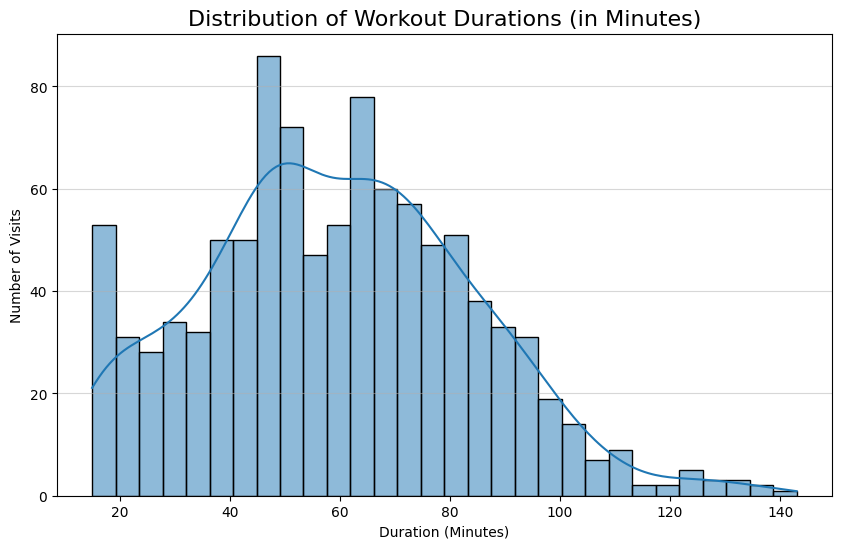

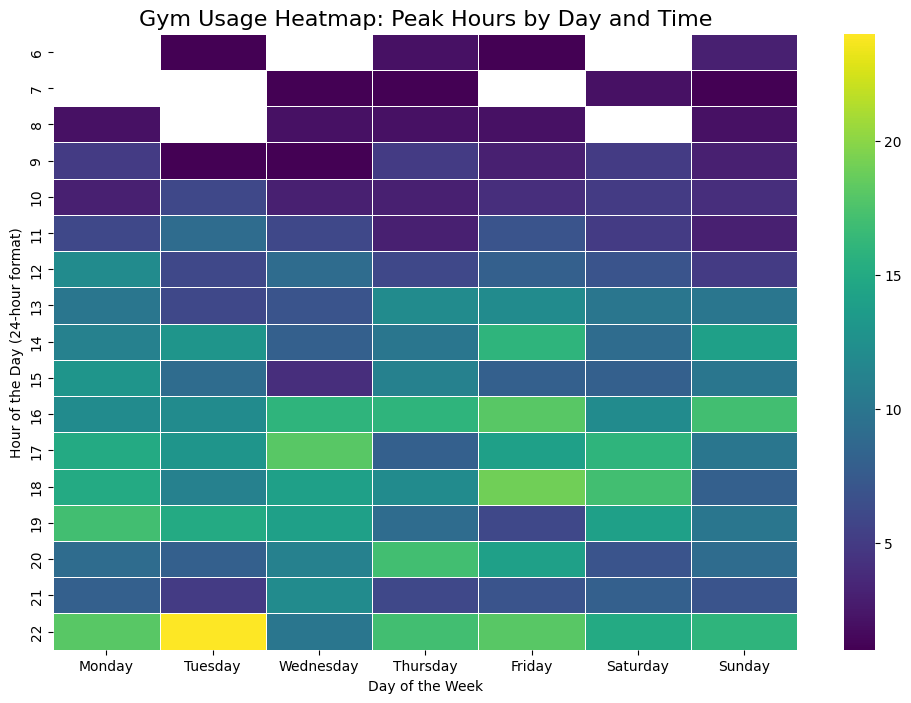

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Analyze Workout Durations ---
plt.figure(figsize=(10, 6))
sns.histplot(df['WorkoutDuration'], bins=30, kde=True)
plt.title('Distribution of Workout Durations (in Minutes)', fontsize=16)
plt.xlabel('Duration (Minutes)')
plt.ylabel('Number of Visits')
plt.grid(axis='y', alpha=0.5)
plt.show()

# --- 2. Identify Peak Hours with a Heatmap ---
# This directly addresses the "heatmaps of gym usage by time/day" deliverable [cite: 11]
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = df.groupby(['HourOfDay', 'DayOfWeek']).size().unstack().reindex(columns=day_order)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", linewidths=.5)
plt.title('Gym Usage Heatmap: Peak Hours by Day and Time', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day (24-hour format)')
plt.show()

/tmp/ipython-input-2773420734.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  footfall = df.set_index('CheckInTimestamp').resample('H').size().reset_index(name='y')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz53tz7gq/nyfmnulb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz53tz7gq/zgn72stq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4375', 'data', 'file=/tmp/tmpz53tz7gq/nyfmnulb.json', 'init=/tmp/tmpz53tz7gq/zgn72stq.json', 'output', 'file=/tmp/tmpz53tz7gq/prophet_modeln93w_hv8/prophet_model-20251007204346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:43:46 - cmds

Data ready for Prophet:
                   ds  y
0 2025-10-01 07:00:00  1
1 2025-10-01 08:00:00  0
2 2025-10-01 09:00:00  0
3 2025-10-01 10:00:00  1
4 2025-10-01 11:00:00  4

✅ Generating the forecast plot...


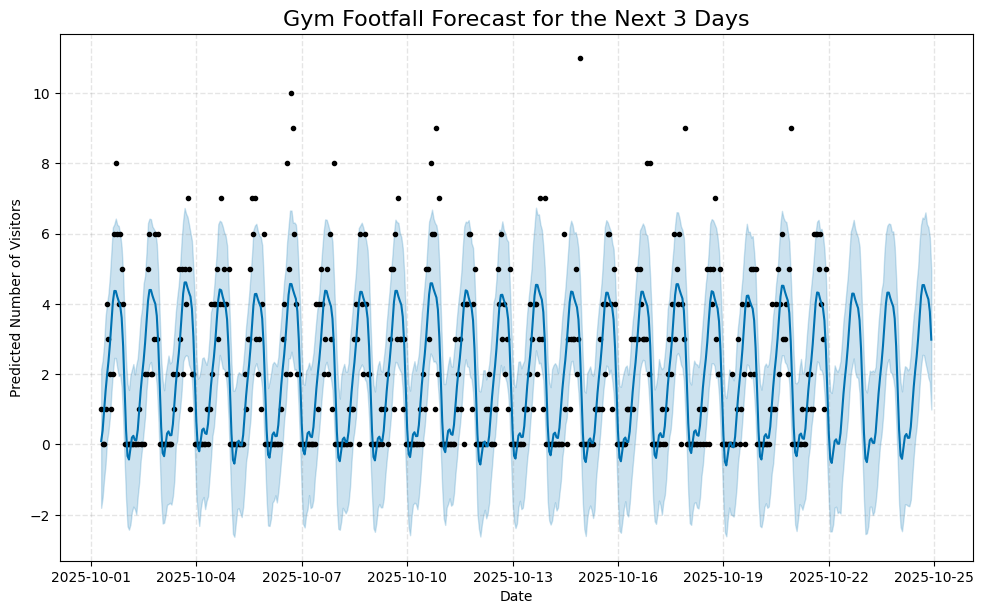

In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt

# --- 1. Prepare Your Data ---
# We count the number of visitors for each hour.
# Prophet requires the columns to be named 'ds' (datestamp) and 'y' (value).
footfall = df.set_index('CheckInTimestamp').resample('H').size().reset_index(name='y')
footfall.rename(columns={'CheckInTimestamp': 'ds'}, inplace=True)

print("Data ready for Prophet:")
print(footfall.head())

# --- 2. Create and Train the Model ---
# We'll train the model on all the data we have.
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(footfall)

# --- 3. Make a Future Forecast ---
# Let's predict the gym usage for the next 3 days (3 * 24 hours).
future_dates = model.make_future_dataframe(periods=3 * 24, freq='H')
forecast = model.predict(future_dates)

# --- 4. Plot the Results ---
# This shows your historical data and the model's future prediction.
print("\n✅ Generating the forecast plot...")
fig = model.plot(forecast)
plt.title('Gym Footfall Forecast for the Next 3 Days', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Predicted Number of Visitors')
plt.grid(True, which='both', linestyle='--')
plt.show()


User profiles for clustering:
  AnonymizedStudentID  total_visits  avg_duration
0      BTECH10001//24            18     59.277778
1      BTECH10005//24            25     55.920000
2      BTECH10015//24            21     54.523810
3      BTECH10050//24            20     55.950000
4      BTECH10056//24            18     64.166667
✅ Clustering Quality (Silhouette Score): 0.39


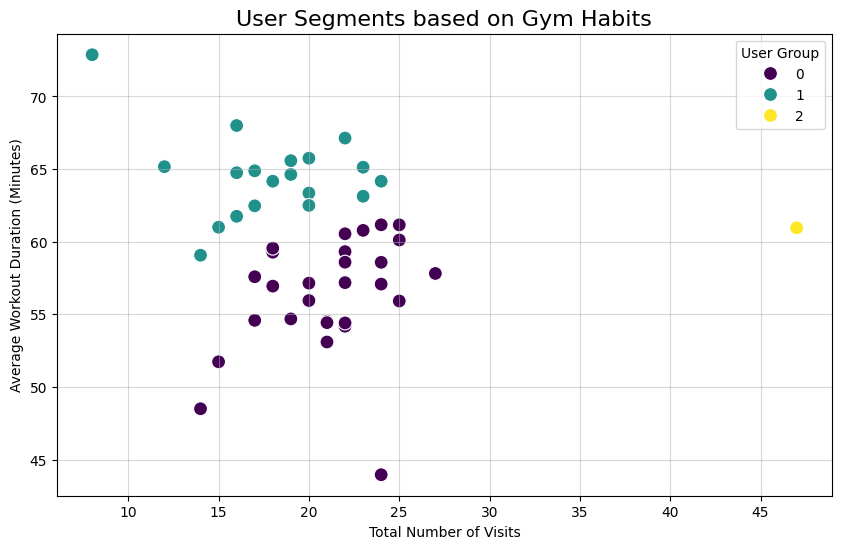

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- 1. Create User Profiles ---
# Aggregate data to get metrics for each student
user_profiles = df.groupby('AnonymizedStudentID').agg(
    total_visits=('CheckInTimestamp', 'count'),
    avg_duration=('WorkoutDuration', 'mean')
).reset_index()

print("\nUser profiles for clustering:")
print(user_profiles.head())

# --- 2. Scale Data and Apply K-Means ---
# It's important to scale data before clustering
features = user_profiles[['total_visits', 'avg_duration']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Let's assume we want to find 3 user segments
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
user_profiles['cluster'] = kmeans.fit_predict(scaled_features)

# --- 3. Evaluate and Visualize Clusters ---
# Calculate Silhouette Score [cite: 19]
score = silhouette_score(scaled_features, user_profiles['cluster'])
print(f"✅ Clustering Quality (Silhouette Score): {score:.2f}")

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_profiles,
    x='total_visits',
    y='avg_duration',
    hue='cluster',
    palette='viridis',
    s=100
)
plt.title('User Segments based on Gym Habits', fontsize=16)
plt.xlabel('Total Number of Visits')
plt.ylabel('Average Workout Duration (Minutes)')
plt.legend(title='User Group')
plt.grid(alpha=0.5)
plt.show()